# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import os
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock
# , run_cbm_emissionstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, plugin_c_curves_both, cbm_report_both, compare_ws3_cbm_both

In [2]:
#Start Calculating the Running Time
Start = time.time()

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'

## Create and Run `ForestModel` instance

In [5]:
fm = ws3.forest.ForestModel(model_name='ecotrust',
                            model_path='data/woodstock_model_files_ecotrust',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

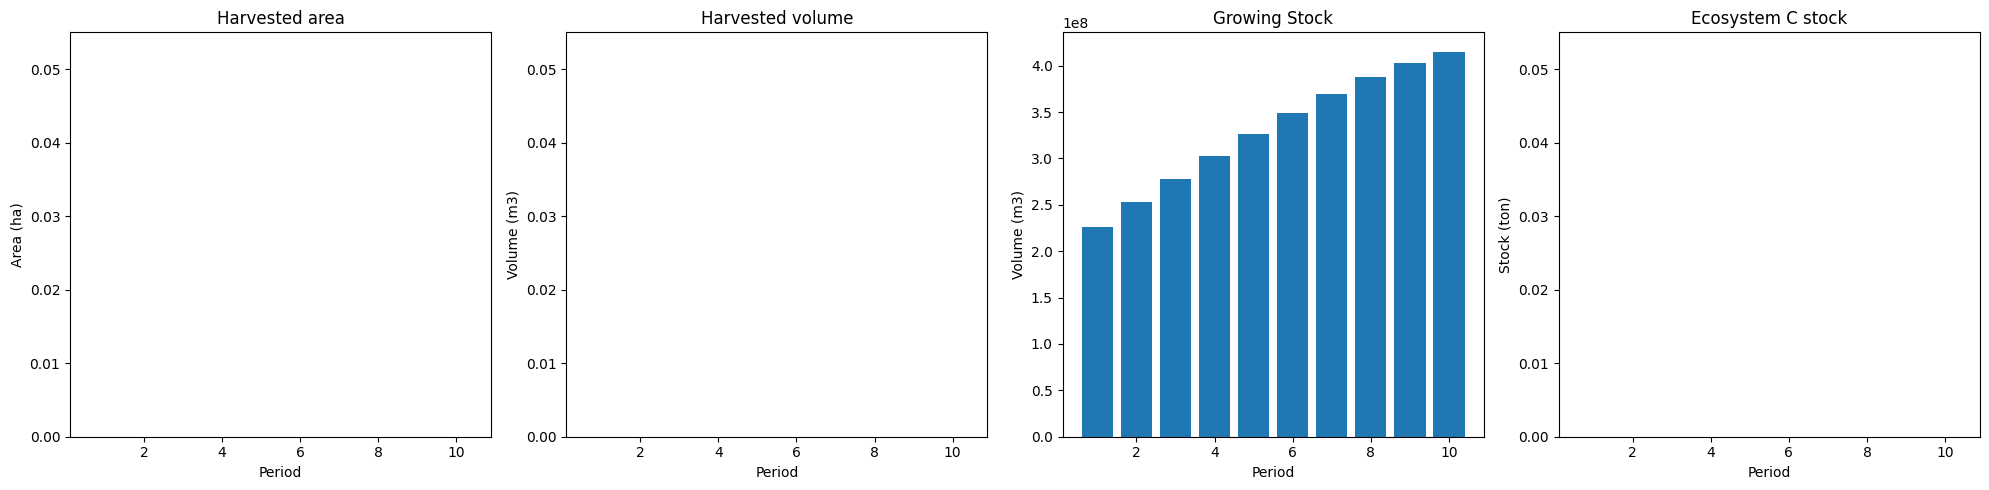

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

In [6]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [ ]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[5] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [ ]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                        disturbance_type_mapping=disturbance_type_mapping)

In [ ]:
from libcbm.input.sit import sit_reader
from libcbm.input.sit import sit_cbm_factory 
from libcbm.model.cbm.cbm_output import CBMOutput
from libcbm.storage.backends import BackendType
from libcbm.model.cbm import cbm_simulator
sit_data = sit_reader.parse(sit_classifiers=sit_tables['sit_classifiers'],
                            sit_disturbance_types=sit_tables['sit_disturbance_types'],
                            sit_age_classes=sit_tables['sit_age_classes'],
                            sit_inventory=sit_tables['sit_inventory'],
                            sit_yield=sit_tables['sit_yield'],
                            sit_events=sit_tables['sit_events'],
                            sit_transitions=sit_tables['sit_transitions'],
                            sit_eligibilities=None)
sit = sit_cbm_factory.initialize_sit(sit_data=sit_data, config=sit_config)
classifiers, inventory = sit_cbm_factory.initialize_inventory(sit)
cbm_output = CBMOutput(classifier_map=sit.classifier_value_names,
                       disturbance_type_map=sit.disturbance_name_map)
with sit_cbm_factory.initialize_cbm(sit) as cbm:
    # Create a function to apply rule based disturbance events and transition rules based on the SIT input
    rule_based_processor = sit_cbm_factory.create_sit_rule_based_processor(sit, cbm)
    # The following line of code spins up the CBM inventory and runs it through 200 timesteps.
    cbm_simulator.simulate(cbm,
                           n_steps=n_steps,
                           classifiers=classifiers,
                           inventory=inventory,
                           pre_dynamics_func=rule_based_processor.pre_dynamics_func,
                           reporting_func=cbm_output.append_simulation_result,
                           backend_type=BackendType.numpy)
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']

In [ ]:
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
ecosystem_pools = biomass_pools + dom_pools

In [ ]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [ ]:
# Define Carbon Fluxes
all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

ecosystem_decay_emissions_pools = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir']
GrossGrowth_pools = [
    'DeltaBiomass_AG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'DeltaBiomass_BG',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput']

In [ ]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = ecosystem_decay_emissions_pools
gross_growth = GrossGrowth_pools
sum_pools = ['ecosystem', 'biomass', 'DOM']

In [ ]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [ ]:
sit_tables['sit_events']

In [ ]:
sit_tables['sit_inventory']

In [ ]:
# Set Age and Area to 1 and 1.0
df = sit_tables['sit_inventory']
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)
df

Use the following code if any of the developments have no harvesting circumstances.

In [ ]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [ ]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

In [ ]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [ ]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [ ]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [ ]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [ ]:
c_curves_f['total_emissions'] = 44/12 * c_curves_f[fluxes].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emissions'] = c_curves_f['total_emissions'] - c_curves_f['gross_growth']

In [ ]:
# Curvs Calibration
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [ ]:
# Use pickle.dump, to store the curves
file_directory = "./inputs/curves"
os.makedirs(file_directory, exist_ok=True)

file_data = {
    f"{case_study}_c_curves_p.pkl": c_curves_p,
    f"{case_study}_c_curves_f.pkl": c_curves_f
}

for filename, data in file_data.items():
    file_path = os.path.join(file_directory, filename)
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
    print(f"File saved at {file_path}")


In [ ]:
# with open(f'{case_study}_c_curves_p_test.pkl', 'rb') as file:
#     c_curves_p = pickle.load(file)

In [ ]:
# with open(f'{case_study}_c_curves_f_test.pkl', 'rb') as file:
#     c_curves_f = pickle.load(file)

In [ ]:
# Plug carbon yield curves into forest model
plugin_c_curves_both(fm, c_curves_p, c_curves_f)
# plugin_c_curves(fm, c_curves_p, pools=sum_pools) # This is only for c_curves_p

In [ ]:
# Check if all carbon yield curves are plugged in well.
fm.yields

In [ ]:
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

In [ ]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

In [ ]:
# Report Annual CBM Outputs
# cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)
cbm_report_both(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

In [ ]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
# compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots="individual")
compare_ws3_cbm_both(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, ecosystem_decay_emissions_pools, GrossGrowth_pools, plots="individual")

In [ ]:
print('It took', round((time.time() - Start) / 60, 1), "minutes to run this script.")